In [2]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import datetime 

# Imports for CLV
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

from sksurv.linear_model import CoxPHSurvivalAnalysis

## Import and Prep Data

In [3]:
# Import Transaction Files
CLV_Feb2016 = pd.read_csv('CLV_Feb2016.csv')
CLV_Feb2016 = CLV_Feb2016.reset_index(drop=True)
CLV_Feb2016 = CLV_Feb2016.drop('Unnamed: 0',axis=1)

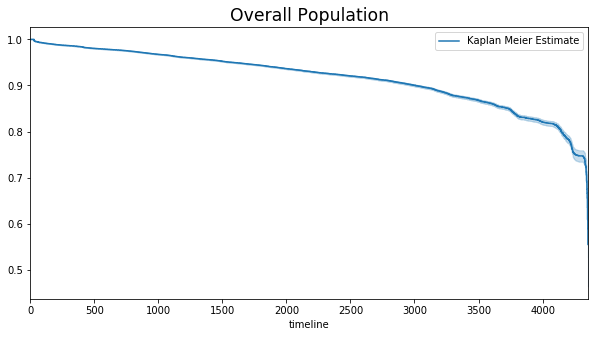

In [5]:
## Time to event data of censored and event data
T = CLV_Feb2016['tenure']

## It has the churned (1) and censored is (0)
E = CLV_Feb2016['is_churn'].apply(lambda x: True if x == 1 else False)

# Instantiate Model
kmf = KaplanMeierFitter()

## Fit the data into the model
kmf.fit(T, E, label='Kaplan Meier Estimate')

## Create an estimate
plt.figure(figsize=(10,5))
plt.title('Overall Population', fontsize='xx-large')
kmf.plot()

### - <font color=blue>Data Pre-Processing</font> -

In [7]:
# Specify the Continuous and Categorical features we will include in our regression model
cont_feat = ['tenure','unique_payment_plans']
cat_feat = ['registered_via','Cluster','city_agg']

# Create df for regression model
CLV_Feb2016 = CLV_Feb2016[['msno','avg_paid_per_day','is_churn'] + cont_feat + cat_feat]

# Encode Categoricals
CLV_Feb2016 = pd.get_dummies(data=CLV_Feb2016, columns=cat_feat, prefix_sep='_',drop_first=True)

# Use PCA to make 1 component for 'registered_via' to prevent multicolinearity errors
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
CLV_Feb2016['registered_via_PCA'] = pca.fit_transform(CLV_Feb2016[['registered_via_4','registered_via_7','registered_via_9','registered_via_10']]).round(decimals=3)

CLV_Feb2016 = CLV_Feb2016.drop(['registered_via_4','registered_via_7','registered_via_9','registered_via_10'], axis=1)

### - <font color=blue>Build CPH Regression Model via Lifelines</font> -

In [8]:
# Instantiate a cph object
cph_lifelines = CoxPHFitter()   

# Fit the data to train the model
model_lifelines = cph_lifelines.fit(CLV_Feb2016[CLV_Feb2016.columns[2:]], duration_col='tenure', event_col='is_churn')

In [9]:
model_lifelines.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
unique_payment_plans,-0.998432,0.368457,0.014871,-1.027579,-0.969285,0.357872,0.379354,-67.138451,0.000000e+00,inf
Cluster_1,0.740052,2.096046,0.015809,0.709068,0.771037,2.032097,2.162006,46.813396,0.000000e+00,inf
Cluster_2,-0.256427,0.773812,0.027653,-0.310626,-0.202227,0.732988,0.816909,-9.272955,1.810581e-20,65.582109
Cluster_3,-0.342694,0.709856,0.066738,-0.473498,-0.211889,0.622820,0.809055,-5.134884,2.823183e-07,21.756174
city_agg_1,0.647356,1.910482,0.029507,0.589523,0.705189,1.803128,2.024228,21.938967,1.103812e-106,351.981883
city_agg_2,-0.244745,0.782904,0.026295,-0.296282,-0.193208,0.743578,0.824311,-9.307716,1.306112e-20,66.053283
city_agg_3,-0.097775,0.906853,0.027483,-0.151641,-0.043909,0.859297,0.957041,-3.557618,3.742326e-04,11.383777
city_agg_4,-0.086367,0.917258,0.023632,-0.132684,-0.040049,0.875742,0.960742,-3.654679,2.575037e-04,11.923119
registered_via_PCA,1.074786,2.929367,0.018351,1.038818,1.110754,2.825876,3.036647,58.567465,0.000000e+00,inf


## 3) Calculate Lifetime Value and Cummulative Harzard Probability

In [14]:
sample = CLV_Feb2016[0:4]

In [15]:
def cumul_hazard_prob(row):
    if row['tenure'] > 4306:
        return model_lifelines.predict_cumulative_hazard(row).iloc[row['tenure']-(row['tenure']-4306)] 
    else: 
        return model_lifelines.predict_cumulative_hazard(row).iloc[row['tenure']]

In [23]:
for index,row in sample.iterrows():
    row.apply(cumul_hazard_prob, axis=1)

TypeError: cumul_hazard_prob() got an unexpected keyword argument 'axis'

In [180]:
sample

,msno,avg_paid_per_day,is_churn,tenure,unique_payment_plans,Cluster_1,Cluster_2,Cluster_3,city_agg_1,city_agg_2,city_agg_3,city_agg_4,registered_via_PCA,Cumm. Hazard Prob
0,CFcdNb91Fh3lVU+vrA/Ur9rZKcHmvrrW/De9JXE1obI=,9.5,0,691,1,1,0,0,1,0,0,0,-0.471,0.042233
1,W6788K7k6Eq/FIe2qZdQZ4FlcQUJrbGja8V8UNFW6T0=,9.5,0,215,1,1,0,0,1,0,0,0,-0.471,NaN
